In [4]:
#python 3.10 required

# %pip install --upgrade pip

# Install the mediapy package for visualizing images/videos.
# See https://github.com/google/mediapy
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
%pip install mediapy remotezip
%pip install git+https://github.com/tensorflow/docs
%pip install -q imageio numpy seaborn ipywidgets tqdm

Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement tensorflow-text~=2.13.0 (from tf-models-official) (from versions: none)
ERROR: No matching distribution found for tensorflow-text~=2.13.0
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple
  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-845j1n71
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-845j1n71
  Resolved https://github.com/tensorflow/docs to commit eae9a407fd74f8caf7715134beddabc6fffdf8d7
  Installing build dependencies ... done
  Getting requirements to build wheel 

In [2]:
!wget https://storage.googleapis.com/thumos14_files/UCF101_videos.zip

Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple
ERROR: tensorflow_text-2.13.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl is not a supported wheel on this platform.
Note: you may need to restart the kernel to use updated packages.


In [10]:
%pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple
  Obtaining dependency information for tensorflow from https://files.pythonhosted.org/packages/6d/b8/de971950e57944531e7c5ffbcbe35fc25aa632f820c36bd2d54ffcfe36cd/tensorflow-2.13.0-cp39-cp39-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata
  Obtaining dependency information for tensorflow-cpu-aws==2.13.0 from https://files.pythonhosted.org/packages/67/66/d8553ad7c0c30c33100cc7a4ae89de6f37f05426743e9fa083fe216e8666/tensorflow_cpu_aws-2.13.0-cp39-cp39-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 200.1 kB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for h5py>=2.9.0 from https://files.pythonhosted.org/packages/55/77/194af7b33a238de92877c884bc398e281a9a2c0e45a2a898faf768ae8660/h5py-3.9.0-cp39-cp39-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata
  Obtaining dependency information for libclang>=13.0.0 from https://fi

In [8]:
%pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://www.piwheels.org/simple
  Obtaining dependency information for opencv-python from https://files.pythonhosted.org/packages/1c/1f/e2fecc126554b84ddea6a159564f3ee21ae9ce52148d72e0d66d655a511c/opencv_python-4.8.0.76-cp37-abi3-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 MB 4.5 MB/s eta 0:00:00:00:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os
import tqdm
import random
import pathlib
import imageio
import itertools
import collections

import cv2
import numpy as np
import remotezip as rz
import seaborn as sns
import zipfile
import matplotlib
import matplotlib.pyplot as plt
from tensorflow_docs.vis import embed

import keras
import tensorflow as tf

2023-10-24 13:06:13.317795: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 13:06:14.622266: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# @title Helper functions for loading data and visualizing
def list_files_per_class(zip_url):
  """
    List the files in each class of the dataset given the zip URL.

    Args:
      zip_url: URL from which the files can be unzipped.

    Return:
      files: List of files in each of the classes.
  """
  files = []
  with zipfile.ZipFile(zip_url) as zip:
  # with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

def get_class(fname):
  """
    Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Return:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

def get_files_per_class(files):
  """
    Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Return:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

def download_from_zip(zip_url, to_dir, file_names):
  """
    Download the contents of the zip file from the zip URL.

    Args:
      zip_url: Zip URL containing data.
      to_dir: Directory to download data to.
      file_names: Names of files to download.
  """
  with zipfile.ZipFile(zip_url) as zip:
  # with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file,)

def split_class_lists(files_for_class, count):
  """
    Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.

    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Return:
      split_files: Files belonging to the subset of data.
      remainder: Dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, duration=200, loop=0)
  return embed.embed_file('./animation.gif')

def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """
    Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: Zip URL containing data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      dir: Posix path of the resulting directories containing the splits of data.
  """
  files = list_files_per_class(zip_url)
  for f in files:
    tokens = f.split('/')
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename

  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    new_files_for_class = files_for_class[cls]
    random.shuffle(new_files_for_class)
    files_for_class[cls] = new_files_for_class

  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in list(files_for_class)[:num_classes]}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

def format_frames(frame, output_size = (172, 172)):
  """
    Pad and resize an image from a video.

    Args:
      frame: Image that needs to resized and padded.
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  convertedframe = tf.image.convert_image_dtype(frame, tf.float32)
  resizedframe = tf.image.resize_with_pad(convertedframe, *output_size)
  return resizedframe

def frames_from_video_file(video_path, n_frames, output_size = (172,172), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

class FrameGenerator:
  def __init__(self, path: pathlib.PosixPath, n_frames, training = False):
    """ Returns a set of frames with their associated label.

      Args:
        path: Video file paths.
        n_frames: Number of frames.
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      try:
        video_frames = frames_from_video_file(path, self.n_frames)
      except:
        continue
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [30]:
URL = pathlib.Path(os.path.join(os.path.abspath(''), 'UCF101_videos.zip'))
download_dir = pathlib.Path('./UCF101_subset/')
num_classes = 101
subset_paths = download_ufc_101_subset(URL,
                        num_classes = num_classes,
                        splits = {"train": 0, "val": 0, "test": 40},
                        download_dir = download_dir)

train :


0it [00:00, ?it/s]

val :



0it [00:00, ?it/s]


test :


100%|██████████| 2000/2000 [00:16<00:00, 119.42it/s]


In [3]:
num_frames = 8
num_classes = 101
batch_size = 1
CLASSES = sorted(os.listdir('./UCF101_subset/test'))
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

test_ds = tf.data.Dataset.from_generator(FrameGenerator(pathlib.PosixPath('UCF101_subset/test/'), num_frames),
                                         output_signature = output_signature)
test_ds = test_ds.batch(batch_size)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(pathlib.PosixPath('UCF101_subset/val/'), num_frames),
                                         output_signature = output_signature)
val_ds = test_ds.batch(batch_size)

for frames, labels in test_ds.take(1):
  print(f"Shape: {frames.shape}")
  print(f"Label: {labels.shape}")

2023-10-24 13:06:35.873572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 13:06:36.154080: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 13:06:36.154330: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 13:06:36.157563: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-24 13:06:36.157858: I tensorflow/compile

Shape: (1, 8, 172, 172, 3)
Label: (1,)


In [4]:
def get_top_k(probs, k=5, label_map=CLASSES):
  """Outputs the top k model labels and probabilities on the given video."""
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  return tuple(zip(top_labels, top_probs))

def quantized_scale(name, state, input_details):
  """Scales the named state tensor input for the quantized model."""
  dtype = input_details[name]['dtype']
  # print(name, dtype)
  scale, zero_point = input_details[name]['quantization']
  if 'frame_count' in name or dtype == np.float32 or scale == 0.0:
    return state
  # return np.cast((state / scale + zero_point), dtype)
  # ret = np.cast[dtype](state / scale + zero_point)
  ret = tf.cast(state/scale+zero_point, dtype)
  # print(ret.dtype)
  return ret

In [39]:
asdf = np.zeros((1,2,3), dtype=np.float32)
sdf = tf.cast(asdf, np.int8)
print(asdf)
print(sdf)
print(asdf.dtype)
print(sdf.dtype)

[[[0. 0. 0.]
  [0. 0. 0.]]]
tf.Tensor(
[[[0 0 0]
  [0 0 0]]], shape=(1, 2, 3), dtype=int8)
float32
<dtype: 'int8'>


{'image': {'name': 'serving_default_image:0', 'index': 37, 'shape': array([  1,   1, 172, 172,   3], dtype=int32), 'shape_signature': array([  1,   1, 172, 172,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, 'state_block0_layer0_pool_buffer': {'name': 'serving_default_state_block0_layer0_pool_buffer:0', 'index': 17, 'shape': array([ 1,  1,  1,  1, 24], dtype=int32), 'shape_signature': array([ 1,  1,  1,  1, 24], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, 'state_block0_layer0_pool_frame_count': {'name': 'serving_default_state_block0_layer0_pool_frame_count:0', 'index': 18, 'shape': array([1], dtype=int32), 'shape_


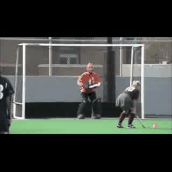

In [6]:
model_path = "tflite_models/model.int8.fallback.tflite"

interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()
runner = interpreter.get_signature_runner()
input_details = runner.get_input_details()
print(input_details)
init_states = {
    name: quantized_scale(name, np.zeros(x['shape'], dtype=x['dtype']), input_details) for name, x in input_details.items() if name != 'image'
    # name: tf.zeros(x['shape'], dtype=x['dtype']) for name, x in input_details.items() if name != 'image'
}
# del init_states['image']

# To run on a video, pass in one frame at a time
states = init_states

  
for frames, label in test_ds.take(1):
  for clip in frames[0]:
    # Input shape: [1, 1, 172, 172, 3]
    # clip = tf.expand_dims(tf.expand_dims(clip, axis=0), axis=0)
    clip_q = tf.expand_dims(tf.expand_dims(quantized_scale('image', clip, input_details), axis=0), axis=0)
    print(tf.shape(clip_q))
    # clip = tf.cast(clip, tf.int32)
    outputs = runner(**states, image=clip_q)
    logits = outputs.pop('logits')[0]
    states = outputs

probs = tf.nn.softmax(logits)
top_k = get_top_k(probs)
print()
for label, prob in top_k:
  print(label, prob)

frames, label = list(test_ds.take(1))[0]
to_gif(frames[0].numpy())

In [67]:
actual = [labels for _, labels in val_ds.unbatch()]

actual = tf.stack(actual, axis=0)

In [71]:
actual_class_idx = actual.numpy()
# print(actual.numpy())
print(CLASSES[actual_class_idx])

TypeError: only integer scalar arrays can be converted to a scalar index

In [10]:
model_path = "tflite_models/model.int8.fallback.tflite"

interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()
runner = interpreter.get_signature_runner()
input_details = runner.get_input_details()

init_states = {
    # name: quantized_scale(name, np.zeros(x['shape'], dtype=x['dtype']), input_details) for name, x in input_details.items() if name != 'image'
    name: tf.zeros(x['shape'], dtype=x['dtype']) for name, x in input_details.items() if name != 'image'
}

# To run on a video, pass in one frame at a time

correct = 0
# total = 2620
total = 9280

with tf.device("/CPU:0"):
  iterator = iter(test_ds.unbatch())
  for i in range(total):
    frames, label = next(iterator, (None, None))
    if frames == None:
      break
    states = init_states
  #   print(frames.shape)
    # to_gif(frames[0].numpy())
    for clip in frames:
    # Input shape: [1, 1, 172, 172, 3]
      # print(clip.shape)
      # clip_q = tf.expand_dims(tf.expand_dims(quantized_scale('image', clip, input_details), axis=0), axis=0)
      clip_q = tf.expand_dims(tf.expand_dims(clip, axis=0), axis=0)
      outputs = runner(**states, image=clip_q)
      logits = outputs.pop('logits')[0]
      states = outputs

    probs = tf.nn.softmax(logits)
    top_k = get_top_k(probs)
    # print("Actual: ", actual)
    # for label, prob in top_k:
    #   print(label, prob)
    pred, _ = top_k[0]
    if pred == CLASSES[label.numpy()]:
        correct += 1
        # print(pred, "=", CLASSES[label.numpy()[0]])
    else:
      # print(pred, "!=", CLASSES[label.numpy()[0]])
      pass
  # print(iterator.get_next())
  # print(list(test_ds.take(1))[0])

print("Accuracy: ", correct/total, '. ', correct, '/', total)


Accuracy:  0.007974137931034483 .  74 / 9280



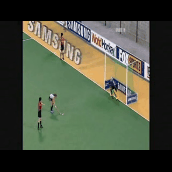

In [58]:
iterator = iter(test_ds.unbatch())
frames, label = iterator.get_next()
label.numpy()
to_gif(frames.numpy())